
Etiket dağılımı:
NORM: 9.0 kayıt
MI: 0.0 kayıt
STTC: 0.0 kayıt
CD: 0.0 kayıt
HYP: 0.0 kayıt

Kayıt 1/10 işleniyor...


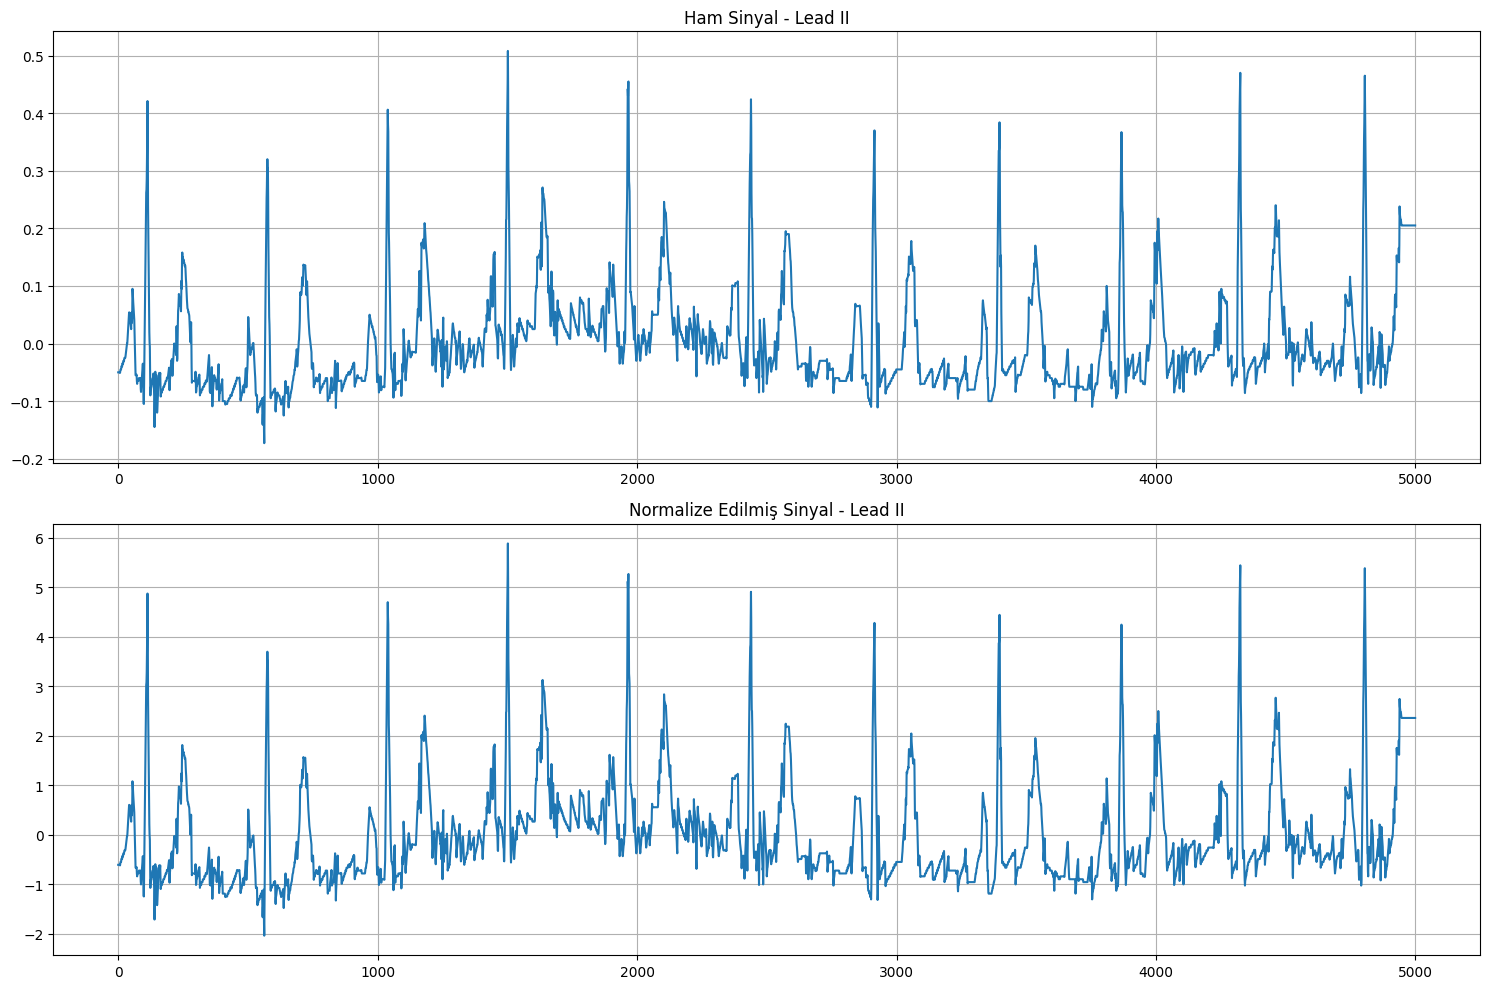


Kayıt 2/10 işleniyor...

Kayıt 3/10 işleniyor...

Kayıt 4/10 işleniyor...

Kayıt 5/10 işleniyor...

Kayıt 6/10 işleniyor...

Kayıt 7/10 işleniyor...

Kayıt 8/10 işleniyor...

Kayıt 9/10 işleniyor...

Kayıt 10/10 işleniyor...

Veri seti boyutları:
Waveforms şekli: (10, 5000, 12)
Labels şekli: (10, 5)

Eğitim ve test seti boyutları:
X_train: (8, 5000, 12)
X_test: (2, 5000, 12)


In [2]:
# Önceki imports...
import pandas as pd
import numpy as np
import wfdb
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# Veri yolu
data_path = Path("d:/ecg/data/raw/ptbxl")

# 1. Veri yükleme fonksiyonları
def load_waveform(record_path):
    """Tek bir EKG kaydını yükle"""
    record = wfdb.rdrecord(str(record_path))
    return record.p_signal

def prepare_labels(df):
    """Tanı etiketlerini hazırla"""
    diagnostic_classes = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    labels = np.zeros((len(df), len(diagnostic_classes)))
    
    for idx, row in df.iterrows():
        scp_codes = eval(row['scp_codes']) if isinstance(row['scp_codes'], str) else row['scp_codes']
        for diagnosis, value in scp_codes.items():
            if diagnosis in diagnostic_classes:
                class_idx = diagnostic_classes.index(diagnosis)
                labels[idx, class_idx] = 1
    
    return labels

# 2. Test için küçük bir veri seti hazırla
n_samples = 10  # İlk 10 kayıt ile başlayalım
df = pd.read_csv(data_path / "ptbxl_database.csv")
df_subset = df.head(n_samples)

# 3. Etiketleri hazırla
labels = prepare_labels(df_subset)
print("\nEtiket dağılımı:")
for i, diagnosis in enumerate(['NORM', 'MI', 'STTC', 'CD', 'HYP']):
    count = labels[:, i].sum()
    print(f"{diagnosis}: {count} kayıt")

# 4. EKG verilerini yükle ve normalize et
waveforms = []
for idx, row in df_subset.iterrows():
    print(f"\nKayıt {idx+1}/{n_samples} işleniyor...")
    
    # Kayıt yolu
    record_path = data_path / row['filename_hr'].replace('.hea', '')
    
    # EKG sinyalini yükle
    waveform = load_waveform(record_path)
    
    # Normalize et
    scaler = StandardScaler()
    waveform_normalized = scaler.fit_transform(waveform)
    
    waveforms.append(waveform_normalized)
    
    # İlk kayıt için görselleştirme
    if idx == 0:
        plt.figure(figsize=(15, 10))
        
        plt.subplot(211)
        plt.plot(waveform[:, 1])  # Lead II
        plt.title('Ham Sinyal - Lead II')
        plt.grid(True)
        
        plt.subplot(212)
        plt.plot(waveform_normalized[:, 1])
        plt.title('Normalize Edilmiş Sinyal - Lead II')
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

waveforms = np.array(waveforms)

print("\nVeri seti boyutları:")
print(f"Waveforms şekli: {waveforms.shape}")
print(f"Labels şekli: {labels.shape}")

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    waveforms, labels,
    test_size=0.2,
    random_state=42
)

print("\nEğitim ve test seti boyutları:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")

In [4]:
# 1. Önce NumPy'ı downgrade et (notebook dışında çalıştır):
# pip install "numpy<2.0"

# 2. Veri boyutlarını düzeltmek için kodu güncelleyelim:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class ECGDataset(Dataset):
    def __init__(self, waveforms, labels):
        # Boyutları düzelt: (batch, time_steps, leads) -> (batch, leads, time_steps)
        self.waveforms = torch.FloatTensor(waveforms).transpose(1, 2)
        self.labels = torch.FloatTensor(labels)
        
    def __len__(self):
        return len(self.waveforms)
    
    def __getitem__(self, idx):
        return self.waveforms[idx], self.labels[idx]

class ECGClassifier(nn.Module):
    def __init__(self, n_leads=12, n_classes=5):
        super().__init__()
        
        self.conv_layers = nn.Sequential(
            # Input: (batch, 12, 5000)
            nn.Conv1d(n_leads, 32, kernel_size=50, stride=3),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv1d(32, 64, kernel_size=15, stride=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2),
            
            nn.Conv1d(64, 128, kernel_size=10, stride=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Dropout(0.2)
        )
        
        # Fully connected katmanlar
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 82, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, n_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

# Model ve veri yükleyicileri
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECGClassifier().to(device)

# Veri yükleyicileri
train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model, kayıp fonksiyonu ve optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Test için bir batch yükle ve boyutları kontrol et
for batch_waveforms, batch_labels in train_loader:
    print("\nBatch boyutları:")
    print(f"Waveforms: {batch_waveforms.shape}")  # Beklenen: (8, 12, 5000)
    print(f"Labels: {batch_labels.shape}")        # Beklenen: (8, 5)
    break

print("\nModel özeti:")
print(model)


Batch boyutları:
Waveforms: torch.Size([8, 12, 5000])
Labels: torch.Size([8, 5])

Model özeti:
ECGClassifier(
  (conv_layers): Sequential(
    (0): Conv1d(12, 32, kernel_size=(50,), stride=(3,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv1d(32, 64, kernel_size=(15,), stride=(2,))
    (5): ReLU()
    (6): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv1d(64, 128, kernel_size=(10,), stride=(1,))
    (9): ReLU()
    (10): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.2, inplace=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=10496, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=5, bias=True)
    (4): Sigmoid()
  )
)


In [7]:
# Eğitim parametreleri
n_epochs = 10
best_loss = float('inf')

# Eğitim ve değerlendirme için metrikler
def calculate_metrics(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).float()
    correct = (y_pred_binary == y_true).float()
    accuracy = correct.mean()
    return accuracy

# Eğitim döngüsü
print("Eğitim başlıyor...")
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Forward pass
        output = model(data)
        loss = criterion(output, target)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrikleri hesapla
        train_loss += loss.item()
        train_acc += calculate_metrics(target, output).item()
        
        # Her 10 batch'te bir durum raporu
        if batch_idx % 10 == 0:
            print(f'Epoch {epoch+1}/{n_epochs} '
                  f'[{batch_idx}/{len(train_loader)}] '
                  f'Loss: {loss.item():.4f}')
    
    # Epoch sonunda ortalama kayıp ve doğruluk
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += criterion(output, target).item()
            val_acc += calculate_metrics(target, output).item()
    
    val_loss /= len(test_loader)
    val_acc /= len(test_loader)
    
    print(f'\nEpoch {epoch+1}/{n_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}\n')
    
    # En iyi modeli kaydet
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')

print("Eğitim tamamlandı!")

Eğitim başlıyor...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (8x12416 and 10496x256)